# Generate Image using Gradio Diffuser

Here's the link if you want to test: https://colab.research.google.com/drive/1iS-zUlq332KXwavp43wSOs612zxm9PYN?usp=sharing

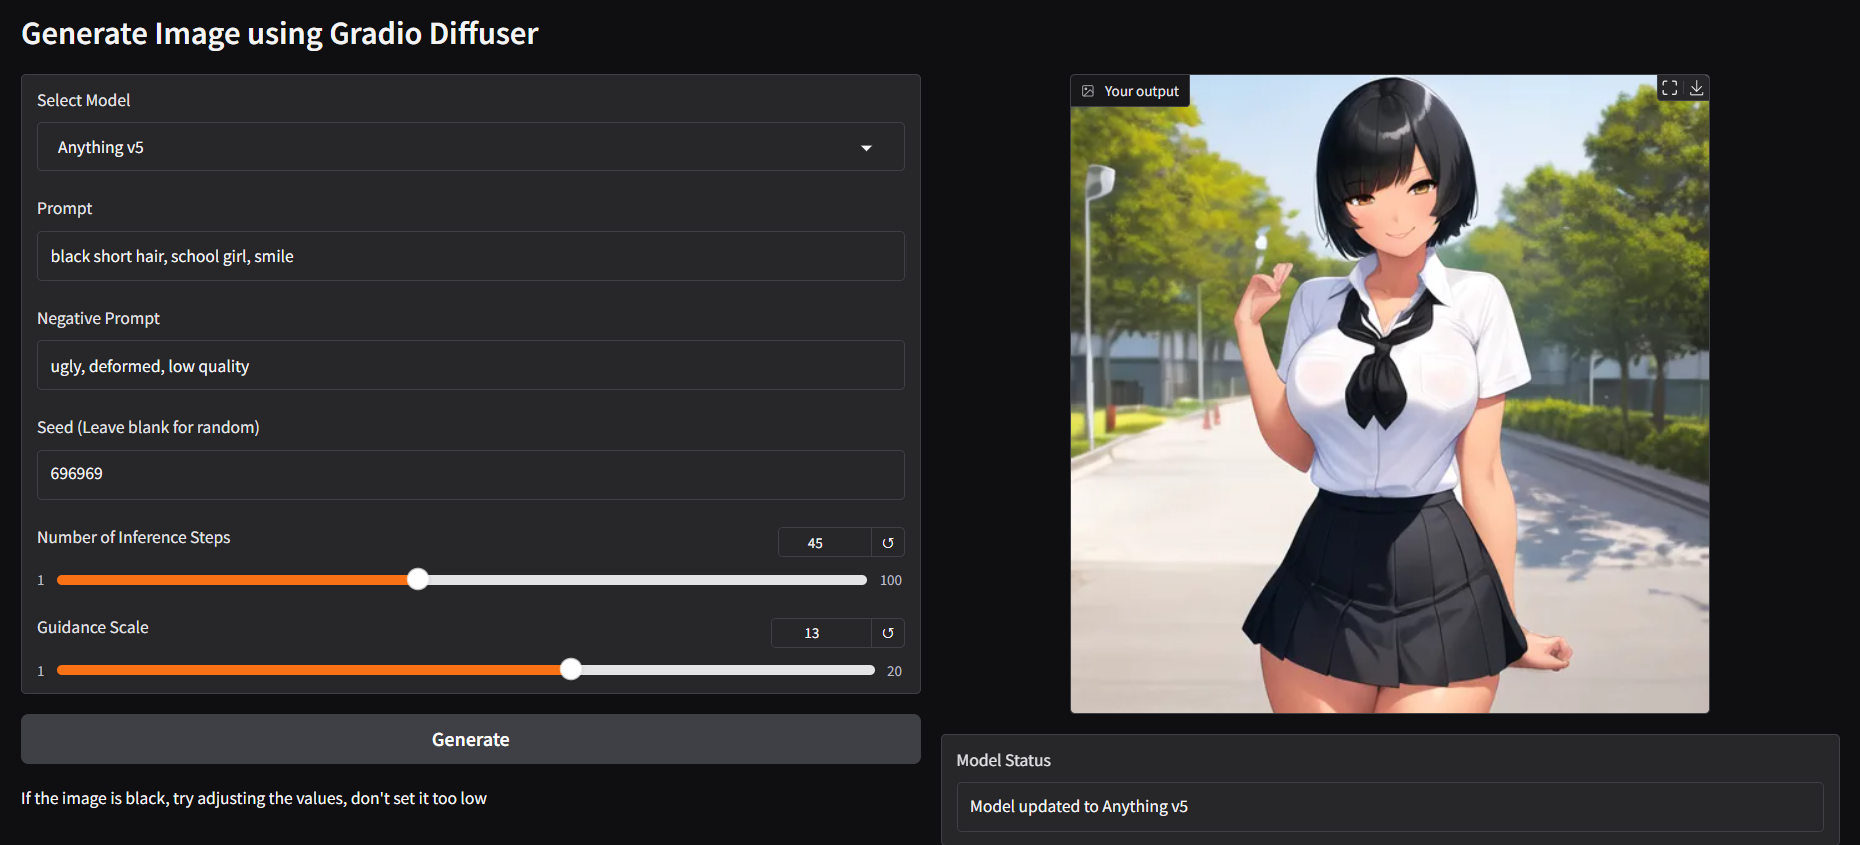

In [ ]:
!pip install gradio diffusers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import gradio as gr
from diffusers import DiffusionPipeline
import torch

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
# Define a dictionary of available models
MODELS = {
    "Stable Diffusion v1.5": "sd-legacy/stable-diffusion-v1-5",
    "Stable Diffusion v2.1": "stabilityai/stable-diffusion-2-1",
    "Anything v5" :"stablediffusionapi/anything-v5"
}

# Pre-load all models into memory
def preload_models():
    models = {}
    for name, path in MODELS.items():
        pipeline = DiffusionPipeline.from_pretrained(
            path,
            torch_dtype=torch.float16,
            use_safetensors=True
        )
        device = "cuda" if torch.cuda.is_available() else "cpu"
        pipeline.to(device)
        models[name] = pipeline
    return models

# Load all models at startup
all_pipelines = preload_models()
current_pipeline = all_pipelines["Stable Diffusion v1.5"]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
import torch

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [ ]:
# Generate image with additional parameters
def generate_image(prompt, negative_prompt, seed, num_inference_steps, guidance_scale):
    global current_pipeline

    # Default values
    if not seed:  # Handle blank seed
        seed = 6969  # Default seed
    if not num_inference_steps:
        num_inference_steps = 35  # Default steps
    if not guidance_scale:
        guidance_scale = 7.5  # Default guidance scale

    # Set the seed
    generator = torch.manual_seed(int(seed))

    # Generate image
    generated_images = current_pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        height=512,
        width=512,
        guidance_scale=float(guidance_scale),
        num_inference_steps=int(num_inference_steps),
        generator=generator
    ).images

    return generated_images[0]

# Function to update the model instantly by switching the reference
def update_model(model_name):
    global current_pipeline
    current_pipeline = all_pipelines[model_name]
    return f"Model updated to {model_name}"

In [ ]:
# Define the Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("# Generate Image using Gradio Diffuser")

    with gr.Row():
        with gr.Column():
            model_dropdown = gr.Dropdown(
                choices=list(MODELS.keys()),
                label="Select Model",
                value="Stable Diffusion v1.5"
            )

            prompt = gr.Textbox(label="Prompt", placeholder="Enter your prompt here")
            negative_prompt = gr.Textbox(label="Negative Prompt", value="ugly, deformed, low quality", placeholder="Enter negative prompt here (optional)")
            seed = gr.Textbox(label="Seed (Leave blank for random)", placeholder="Enter seed (optional)")
            num_inference_steps = gr.Slider(label="Number of Inference Steps", minimum=1, maximum=100, value=35, step=1)
            guidance_scale = gr.Slider(label="Guidance Scale", minimum=1.0, maximum=20.0, value=7.5, step=0.1)
            generate_button = gr.Button("Generate")
            gr.Markdown("If the image is black, try adjusting the values, don't set it too low")

        with gr.Column():
            image_output = gr.Image(label="Your output", height=512, width=512)
            model_status = gr.Textbox(label="Model Status", interactive=False)

    # Connect the dropdown change event to the update_model function
    model_dropdown.change(fn=update_model, inputs=model_dropdown, outputs=model_status)

    # Connect the generate button to the generate_image function
    generate_button.click(
        fn=generate_image,
        inputs=[prompt, negative_prompt, seed, num_inference_steps, guidance_scale],
        outputs=image_output
    )

# Launch the Gradio interface
demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://942c2aa798dd07758e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
